**<h3>Predykcja płci użytkownika na podstawie danych z twittera <br> </h3>**
 <h5> Celem poniższej pracy domowej jest predykcja płci użytkownika twittera na podstawie danych pobranych z https://www.kaggle.com/crowdflower/twitter-user-gender-classification i porównanie modeli zbudowanych na różnych podzbiorach danych. <br> <br>
 Udostępniony zbiór można podzielić na:
*  informacje o profilu użytkownika, takie jak kolorystyka paska bocznego, opis profilu, czas założenia konta, płeć itp.
*  informacje o losowym wpisie na twitterze np. tresć tweeta, lokalizacja użytkownika w chwili umieścienia wpisu itp. 

<br>
Aby nie skupiać się na technikach przetwarzania tekstu przekształcę jedynie kolumny zawierające opis profilu i tekst tweetów na wektory o długości 512 za pomocą Universal Sentence Encodera: https://arxiv.org/pdf/1803.11175.pdf 


Porównam klasyfikatory płci (male/female/ brand for non-human profiles) wytrenowane na:


1. Informacjach na profilu użytkownika takich jak kolorystyka paska bocznego, liczba ulubionych tweetów, stanu obserwacji (bez opisu profilu i cech takich jak daty i lokalizacje)
2.  Wyłącznie na podstawie embeddingów tekstu powstałych na podstawie losowego tweeta.
3.   Wyłącznie na podstawie embeddingów tekstu powstałych na podstawie opisu o użytkowniku w profilu.






 





In [2]:
import tensorflow_hub as hub
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import seaborn as sns


In [17]:
data = pd.read_csv("gender-classifier-DFE-791531.csv",encoding='latin1')
df = data.drop({"name","created","_last_judgment_at","tweet_created","tweet_id","user_timezone","tweet_location","profileimage","gender_gold","profile_yn_gold","tweet_coord","_unit_id"},1)
df = df.dropna(subset=['gender', 'gender:confidence','description','sidebar_color'])
df = df[df['gender']!="unknown"].reset_index(drop=True)
description = df.description
text = df.text

Postać danych:

In [19]:
df.head()

,_golden,_unit_state,_trusted_judgments,gender,gender:confidence,profile_yn,profile_yn:confidence,description,fav_number,link_color,retweet_count,sidebar_color,text,tweet_count
0,False,finalized,3,male,1.0000,yes,1.0,i sing my own rhythm.,0,08C2C2,0,FFFFFF,Robbie E Responds To Critics After Win Against...,110964
1,False,finalized,3,male,1.0000,yes,1.0,I'm the author of novels filled with family dr...,68,0084B4,0,C0DEED,ÛÏIt felt like they were my friends and I was...,7471
2,False,finalized,3,male,0.6625,yes,1.0,louis whining and squealing and all,7696,ABB8C2,1,C0DEED,i absolutely adore when louis starts the songs...,5617
3,False,finalized,3,male,1.0000,yes,1.0,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",202,0084B4,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,1693
4,False,finalized,3,female,1.0000,yes,1.0,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,37318,3B94D9,0,0,Watching Neighbours on Sky+ catching up with t...,31462


W licznościach kategorii zmiennej objaśnianej nie ma wielkich różnic:



<BarContainer object of 3 artists>

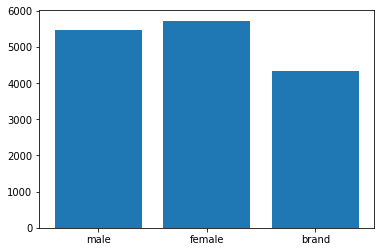

In [4]:
plt.bar(Counter(df.gender).keys(), Counter(df.gender).values())

In [5]:
def split_train_test_validate(df: pd.DataFrame,
                              X_columns: list,
                              no_model: int):

    if no_model!=1:
      df = df.sample(frac=1).reset_index(drop=True)
      gender = df.gender
      embed = hub.Module("https://tfhub.dev/google/universal-sentence-encoder/1")
      if no_model==2:
        embedding = embed(df.text)
      else:
        embedding = embed(df.description)

      with tf.Session() as session:
        session.run([tf.global_variables_initializer(), tf.tables_initializer()])
        embedding = session.run(embedding)

      df = pd.DataFrame(embedding)
      onehot_enc = OneHotEncoder(handle_unknown='ignore')
      onehot_enc.fit(pd.DataFrame(pd.DataFrame(gender)))
      gender = onehot_enc.transform(pd.DataFrame(gender))

    elif no_model==1:
      df = df.sample(frac=1).reset_index(drop=True).drop(["text", "description"], 1)
      label_encoder = LabelEncoder()
      for col in ['_unit_state','_golden','gender','profile_yn','link_color','sidebar_color']:
          df[col] = label_encoder.fit_transform(df[col])
      gender = df.gender
      df = df.drop("gender",1)
      onehot_enc = 0
          


    test = df[:2000]
    validate = df[2000:5522].reset_index(drop=True)
    train = df[5522:].reset_index(drop=True)

    return train, gender[5522:], test, gender[:2000], validate, gender[2000:5522], onehot_enc

In [6]:
def find_best_nn(X_train, y_train, X_test, y_test, onehot_enc):
  epochs =30
  best_acc = 0
  y_test = [onehot_enc.categories_[0].tolist().index(value) for value in list(onehot_enc.inverse_transform(y_test))]
  for batch_size in [16,64]:
      for activation in ['relu', 'sigmoid']:
          for layer_size in [32,64]:
              for hidden_layer in ["no_hidden","one","two"]:
                  classifier = Sequential()
                  classifier.add(Dense(layer_size, activation=activation, input_dim=X_train.shape[1]))
                  if hidden_layer!="no_hidden":
                      classifier.add(Dense(int(layer_size/2), activation=activation))
                  if hidden_layer=="two":
                      classifier.add(Dense(int(layer_size/4), activation=activation))

                  classifier.add(Dense(3))
                  classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])
                  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
                  training_history = classifier.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                                                    validation_split=0.2, verbose=0, callbacks=[es])

                  test_acc = accuracy_score(np.argmax(classifier.predict(X_test), axis=1), y_test)
                  if best_acc < test_acc:
                      best_acc = test_acc
                      best_model={"test_accuracy":test_acc,
                                    "batch_size":batch_size,
                                    "activation":activation,
                                    "layer_size":layer_size,
                                    "hidden_layer":hidden_layer,
                                    "history":training_history,
                                    "model":classifier}
                  
  return best_model
                    
                

In [7]:
def run_model(model, X_train, y_train, X_test, y_test):
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  print(sns.heatmap(pd.DataFrame(classification_report(pred, y_test,output_dict=True)).iloc[:-1, :4].T,annot=True))

*Poniższe wykresy maja różne skale, zatem kolory są wskazówką do porównania równowagi między precyzją, a recallem w obrębie jednego modelu.*


**Model I** <br>
Porównanie wyników: SVM, Regresji Logistycznej i Lasów losowych. <br> <br>


In [11]:
X_train, y_train, X_test, y_test, X_validate, y_validate, onehot_enc=split_train_test_validate(df, ['_golden','_unit_state','_trusted_judgments','gender:confidence','profile_yn','profile_yn:confidence','fav_number','link_color','retweet_count','sidebar_color','tweet_count'], 1)

Prezycja, recall, f1-score i accuracy dla Regresji Logistycznej



AxesSubplot(0.125,0.125;0.62x0.755)


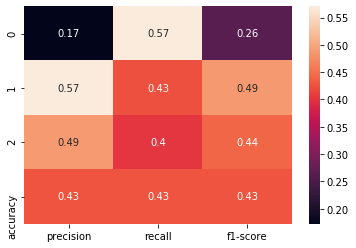

In [33]:
run_model(LogisticRegression(), X_train, y_train, X_test, y_test)

Prezycja, recall, f1-score i accuracy dla SVM

AxesSubplot(0.125,0.125;0.62x0.755)


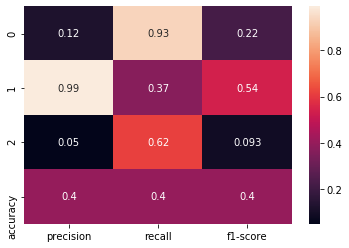

In [34]:
run_model(SVC(gamma='auto'), X_train, y_train, X_test, y_test)

Prezycja, recall, f1-score i accuracy dla Lasu losowego


AxesSubplot(0.125,0.125;0.62x0.755)


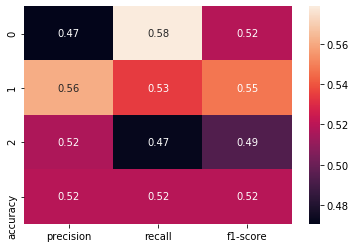

In [39]:
run_model(RandomForestClassifier(n_estimators=100,max_depth=7), X_train, y_train, X_test, y_test)

**Model II** - sieć neuronowa na podstawie tekstu z losowego tweeta<br> 
Przekształciłam każdy teskt za pomocą USE na embedding. Następnie przepuściłam przez prostą sieć neuronową (z jedną, dwoma lub bez warstwy ukrytej). Sprawdzona została funkcja relu i funkcja sigmoidalna jako funkcje aktywacji, 32 i 64 jako wielkości warstw ukrytych, a także dodałam wcześniejsze zatrzymanie treningu z opóźnieniem o 2 epoki w przypadku gdy sieć przestaje się uczyć. 


In [15]:
X_train, y_train, X_test, y_test, X_validate, y_validate, onehot_enc=split_train_test_validate(df,[], 2)

In [16]:
model = find_best_nn(X_train, y_train, X_test, y_test, onehot_enc)

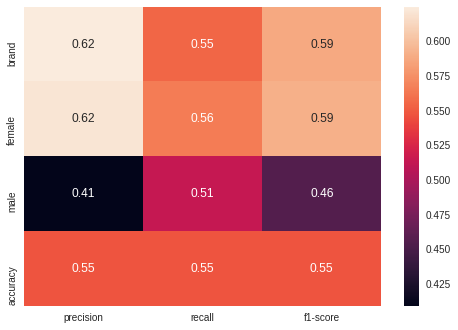

In [56]:
sns.heatmap(pd.DataFrame(classification_report(np.argmax(model['model'].predict(X_validate),axis=1), [onehot_enc.categories_[0].tolist().index(value) for value in list(onehot_enc.inverse_transform(y_validate))],target_names=onehot_enc.categories_[0].tolist(),output_dict=True)).iloc[:-1, :4].T,annot=True)

**Model III** <br>
Analogiczna sieć do tej z modelu drugiego. Różnicę stanowią dane wejściowe do sieci - tutaj celem modelu jest klasyfikacja płci użytkownika na podstawie opisu na profilu.

In [57]:
X_train, y_train, X_test, y_test, X_validate, y_validate, onehot_enc=split_train_test_validate(df,[], 3)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [58]:
model3 = find_best_nn(X_train, y_train, X_test, y_test, onehot_enc)

Epoch 00005: early stopping
Epoch 00004: early stopping
Epoch 00004: early stopping
Epoch 00003: early stopping
Epoch 00003: early stopping
Epoch 00003: early stopping
Epoch 00003: early stopping
Epoch 00005: early stopping
Epoch 00007: early stopping
Epoch 00005: early stopping
Epoch 00003: early stopping
Epoch 00007: early stopping
Epoch 00008: early stopping
Epoch 00006: early stopping
Epoch 00010: early stopping
Epoch 00008: early stopping
Epoch 00004: early stopping
Epoch 00005: early stopping
Epoch 00005: early stopping
Epoch 00007: early stopping
Epoch 00013: early stopping
Epoch 00003: early stopping
Epoch 00006: early stopping
Epoch 00006: early stopping


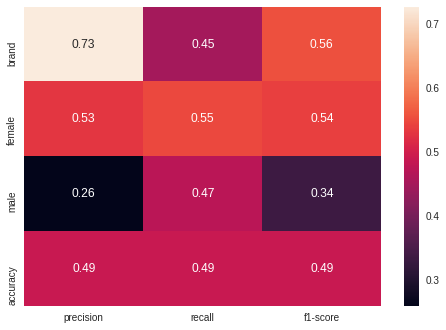

In [59]:
sns.heatmap(pd.DataFrame(classification_report(np.argmax(model['model'].predict(X_validate),axis=1), [onehot_enc.categories_[0].tolist().index(value) for value in list(onehot_enc.inverse_transform(y_validate))],target_names=onehot_enc.categories_[0].tolist(),output_dict=True)).iloc[:-1, :4].T,annot=True)

**Podsumowanie** <br>
Porównując modele: SVM, Regresję Logistyczną i Lasy losowe, najwyższy wynik (accuracy) osiągnęły lasy losowe. Miały one także najbardziej "stabilne" wyniki pod względem częstotliwości przewidywania danych klas (SVM'y dosyć często na pytanie: Jaką płeć ma użytkownik X_i? błędnie odpowiadały, że był to "brand for non-human profiles" (0)). <br>
<br>
Spośród wszystkich modeli najlepsze wyniki osiągnął Model II.  Być może lepsze wyniki można by uzyskać za pomocą innym metod przetwarzania języka naturalnego. Jednak na podstawie powyższych metod, można postawić tezę, iż najprościej przewidzieć płeć użytkownika twittera na podstawie jego tweetów.
